# Final project - MovieLens recommendation

In [1]:
"""
#check if GPU is working when this notebook running on Google Colab
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n#check if GPU is working when this notebook running on Google Colab\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [2]:
#import libraries
#using !pip to install libraries on Google Colab

#!pip install bottleneck
#!pip install lightfm
import numpy as np
import pandas as pd
import scipy.sparse
from scipy import sparse
from scipy.sparse import csr_matrix
import math
import lightfm
from lightfm import cross_validation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import shutil
import sys
#from tensorflow.contrib.layers import apply_regularization, l2_regularizer
#import bottleneck as bn

/Users/ycr/anaconda3/envs/recsys/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# Data Description

In [5]:
original = pd.read_csv(('Data/ml-latest/ratings.csv'), header=0)
original.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [7]:
n_users = original.userId.unique().shape[0]
n_items = original.movieId.unique().shape[0]
sparsity = float(original.shape[0]) / float(n_users*n_items) * 100

print("In the original data, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (original.shape[0], n_users, n_items, sparsity))

In the original data, there are 27753444 rating events from 283228 users and 53889 movies (sparsity: 0.182%)


# FM

## Data processing

In [9]:
#dataset = original.sample(frac=0.1, replace=True)   #if you want to randomly sample the original data, uncomment this line
dataset = original  
n_users = dataset.userId.unique().shape[0]
n_items = dataset.movieId.unique().shape[0]
sparsity = float(dataset.shape[0]) / float(n_users*n_items) * 100

print("Before filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (dataset.shape[0], n_users, n_items, sparsity))

Before filtering, there are 2775344 rating events from 237948 users and 29430 movies (sparsity: 0.040%)


In [3]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count
def filter_triplets(tp, min_uc=0, min_sc=0):
    # Only keep the triplets for items which were rated by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who rated at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

Only keep items that are rated by at least 50 users

In [11]:
dataset, user_fm, item_fm = filter_triplets(dataset,min_sc = 50)

In [12]:
sparsity = 1. * dataset.shape[0] / (user_fm.shape[0] * item_fm.shape[0])

print("After filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%) for lightfm" % 
      (dataset.shape[0], user_fm.shape[0], item_fm.shape[0], sparsity * 100))

After filtering, there are 2608029 rating events from 236736 users and 5577 movies (sparsity: 0.198%) for lightfm


In [13]:
dataset.head()

,userId,movieId,rating,timestamp
6788440,69734,780,4.0,1279883119
26499140,270637,3468,4.0,1168582514
18890007,192755,849,2.5,1245532324
20368836,207751,143355,3.0,1522181849
346770,3507,635,4.0,855839923


In [14]:
def sparse_matrix(dataset):
    movieId_to_idx = {}
    idx_to_movieId = {}
    for (idx, movieId) in enumerate(dataset.movieId.unique().tolist()):
        movieId_to_idx[movieId] = idx
        idx_to_movieId[idx] = movieId
    
    userId_to_idx = {}
    idx_to_userId = {}
    for (idx, userId) in enumerate(dataset.userId.unique().tolist()):
        userId_to_idx[userId] = idx
        idx_to_userId[idx] = userId
    
    def map_ids(row, mapper):
        return mapper[row]
    
    I = dataset.userId.apply(map_ids, args=[userId_to_idx]).values
    J = dataset.movieId.apply(map_ids, args=[movieId_to_idx]).values
    V = np.ones(I.shape[0])
    data = scipy.sparse.coo_matrix((V, (I, J)), dtype=np.float64)
    data = data.tocsr()
    return data

In [15]:
data = sparse_matrix(dataset)

### train/test split

In [16]:
train, test = lightfm.cross_validation.random_train_test_split(data,0.2)

## Model training

### evaluation metrics

In [17]:
def ndcgatk(x_test, x_predict, k):
    ndcg_values = []
    total_ndcg = 0.0
    best  = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

        if len(top_rated_movies_idx) == 0:
            #print("test user has no 1 rated movies: ", i)
            continue
        sorted_ratings = x_predict[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]
        sum_ndcg = 0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                ndcg = 1/(math.log(i+2))
            else:
                dcg = 0
            sum_ndcg += ndcg

        total_ndcg += sum_ndcg
        ndcg_values.append(sum_ndcg)

    ndcg_values = np.array(ndcg_values)
    max_ndcg = ndcg_values.max()
    ndcg_values = ndcg_values / max_ndcg 
    total_ndcg = np.sum(ndcg_values)

    return total_ndcg/float(len(ndcg_values))

In [18]:
def recallatk(x_test, x_predict, k):
    recall_values = []
    total_recall = 0.0
    for i in range(len(x_test)):
        top_rated_movies_idx = [i for i, x in enumerate(x_test[i].tolist()) if x == 1.0]

        if len(top_rated_movies_idx) == 0:
            #print("test user has no 1 rated movies: ", i)
            continue

        sorted_ratings = x_predict[i].tolist()
        top_predicted_movies_idx = sorted(range(len(sorted_ratings)), key=lambda i: sorted_ratings[i])[-k:]

        sum = 0.0
        for i in range(0, k):
            if top_predicted_movies_idx[i] in top_rated_movies_idx:
                sum+=1.0
        recall = sum/float(min(k, len(top_rated_movies_idx)))
        total_recall += recall
        recall_values.append(recall)
    return total_recall/float(len(recall_values))

### without side information

In [19]:
from lightfm import LightFM
from lightfm.evaluation import recall_at_k

In [20]:
#only use one epoch because of the running time
model = LightFM(learning_rate=0.05,loss = 'warp')
model.fit(train)

In [21]:
uid = list(range(0,train.shape[0]))
mid = list(range(0,train.shape[1]))
predict_train = []
for i in uid:
    predict = model.predict(i, mid)
    predict_train.append(predict.tolist())
predict_train = np.array(predict_train)

predict_test = []
for i in uid:
    predict = model.predict(i, mid)
    predict_test.append(predict.tolist())
predict_test = np.array(predict_test)

x_train = train.toarray()
x_test = test.toarray()
recall_train = recallatk(x_train,predict_train,20)
ndcg_train = ndcgatk(x_train, predict_train,100)
recall_test = recallatk(x_test,predict_test,20)
ndcg_test = ndcgatk(x_test, predict_test,100)

In [24]:
print('Recall@20: train %.2f, test %.2f.' % (recall_train, recall_test))
print('NDCG@100: train %.2f, test %.2f.' % (ndcg_train, ndcg_test))

Recall@20: train 0.10, test 0.09.
NDCG@100: train 0.08, test 0.05.


# CF

In [4]:
import surprise
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader

In [42]:
reader = Reader(line_format='user item rating', sep=',', skip_lines=3, rating_scale=(1, 5))
cf_data=pd.read_csv('Data/ml-latest/ratings.csv')
cf_data=cf_data.drop(['timestamp'],axis=1)
cf_data, user_fm, item_fm = filter_triplets(cf_data,min_sc = 50)
cf_data=Dataset.load_from_df(cf_data,reader=reader)

In [43]:
#neighbor_size=np.arange(40,100,15)
#param_grid = {'k': neighbor_size}
#knn=GridSearchCV(KNNBaseline,param_grid)
#knn.fit(cf_data)
#bestk = knn_gs.best_params['mae']['k']
#algo=KNNBaseline(k=bestk)
trainset, testset = train_test_split(cf_data, test_size=.2)
algo = KNNBaseline(k=80)
algo.fit(trainset)
#predict_train = algo.test(trainset)
#predict_test = algo.test(testset)
#c_v=cross_validate(algo, cf_data,cv=10,return_train_measures =True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [44]:
predict_test = algo.test(testset)

In [54]:
from collections import defaultdict
def surprise_recall_at_k(predictions, k=10, threshold=4):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return recalls

In [57]:
recalls_test_20 = surprise_recall_at_k(predict_test,20)
recall_test_20 = sum(rec for rec in recalls_test_20.values()) / len(recalls_test_20)
recalls_test_50 = surprise_recall_at_k(predict_test,50)
recall_test_50 = sum(rec for rec in recalls_test_50.values()) / len(recalls_test_50)

In [58]:
#recall_test = recallatk(testset,predict_test,20)
#ndcg_test = ndcgatk(testset, predict_test,100)
print('Recall@20: test %.2f.' % (recall_test_20))
print('Recall@50: test %.2f.' % (recall_test_50))
#print('NDCG@100: train %.2f, test %.2f.' % (ndcg_train, ndcg_test))

Recall@20: test 0.33.
Recall@50: test 0.35.


# SVD

In [48]:
from surprise import SVDpp
algo = SVDpp(lr_all = 0.011, reg_all = 0.1)
algo.fit(trainset)
predict_test = algo.test(testset)

In [49]:
recalls_test_20 = surprise_recall_at_k(predict_test,20)
recall_test_20 = sum(rec for rec in recalls_test_20.values()) / len(recalls_test_20)
recalls_test_50 = surprise_recall_at_k(predict_test,50)
recall_test_50 = sum(rec for rec in recalls_test_50.values()) / len(recalls_test_50)
print('Recall@20: test %.2f.' % (recall_test_20))
print('Recall@50: test %.2f.' % (recall_test_50))

Recall@20: test 0.63.
Recall@50: test 0.70.


# VAE

## Data preprocessing

We load the data and create train/validation/test splits following strong generalization: 

- We split all users into training/validation/test sets. 

- We train models using the entire click history of the training users. 

- To evaluate, we take part of the click history from held-out (validation and test) users to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen click history from the held-out users.

We need to binarize the data for vae.                     
We only keep ratings >= 4.0

In [0]:
# binarize the data (only keep ratings >= 4)
raw_data = original[original['rating'] > 3.5]

In [0]:
raw_data.head()

,userId,movieId,rating,timestamp
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
11,1,3020,4.0,1256677260


### Data splitting procedure

- Select 10K users as heldout users, 10K users as validation users, and the rest of the users for training
- Use all the items from the training users as item set
- For each of both validation and test user, subsample 80% as fold-in data and the rest for prediction 

In [0]:
n_users = raw_data.userId.unique().shape[0]
n_items = raw_data.movieId.unique().shape[0]
sparsity = float(raw_data.shape[0]) / float(n_users*n_items) * 100

print("Before filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], n_users, n_items, sparsity))

Before filtering, there are 13839395 rating events from 277240 users and 37198 movies (sparsity: 0.134%)


Only keep items that are rated by at least 50 users

In [0]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data,min_sc=50)

In [0]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d rating events from %d users and %d movies (sparsity: %.3f%%) for VAE" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 13634186 rating events from 277045 users and 9053 movies (sparsity: 0.544%) for VAE


In [0]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [0]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 10000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [0]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [0]:
unique_sid = pd.unique(train_plays['movieId'])

In [0]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [0]:
#with open(('unique_sid.txt'), 'w') as f:
 #   for sid in unique_sid:
  #      f.write('%s\n' % sid)

In [0]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [0]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [0]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [0]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [0]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


### Save the data into (user_index, item_index) format

In [0]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [0]:
train_data = numerize(train_plays)
train_data.to_csv(('train.csv'), index=False)

In [0]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(('validation_tr.csv'), index=False)

In [0]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(('validation_te.csv'), index=False)

In [0]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(('test_tr.csv'), index=False)

In [0]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(('test_te.csv'), index=False)

### get item-embedding

we binarize the genomes by seeting the tpo 20 genomes of each movie to 1, and the others to 0.

In [0]:
#get_genomes.py
import json
from operator import itemgetter
import numpy as np
NUM_GENOMES = 1128
num_genomes = 1128

#converts tuple to a 1128 dim vector
def get_genome_vec(genome_tup):
    vec = np.zeros(NUM_GENOMES)
    #print len(genome_tup)
    for i in genome_tup:
        tag = int(i[0])-1
        vec[tag] = 1
    return vec


with open('genome-scores.csv', 'r') as f:
    genome_data = f.read().splitlines()

genome_dict = {}

#Collect all the genomes in genomes-scores.csv
for i in genome_data[1:]:
    i = i.split(",")
    mid = i[0]
    tagid = i[1]
    relevance = float(i[2])
    try :
        genome_dict[mid].append((tagid, relevance))
    except:
        genome_dict[mid] = [(tagid, relevance)]
        

#sort and select genomes
for mid in genome_dict.keys():
    scores = genome_dict[mid]
    scores = sorted(scores , key=itemgetter(1), reverse = True)
    scores = scores[:20]
    genome_dict[mid] = scores
    #print len(genome_dict[mid])

with open('genome_scores.json', 'w') as f:
    json.dump(genome_dict, f)

unk = np.array([0]*num_genomes)
movie_embeddings_array = []

#conv_idert list to a one hot vector
movie_id = raw_data['movieId'].unique()

for i in movie_id:
    try:
        movie_embeddings_array.append(get_genome_vec(genome_dict[mid]))
    except KeyError:
        movie_embeddings_array.append(unk)

movie_embeddings_array = np.array(movie_embeddings_array)
#with open('movie_genomes.npy', 'wb') as f:
 #   np.save(f, movie_embeddings_array)

## Model definition and training

We define two related models: denoising autoencoder with multinomial likelihood (Multi-DAE in the paper) and partially-regularized variational autoencoder with multinomial likelihood (Multi-VAE^{PR} in the paper).

### Model definition

__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. It is straightforward to extend it to general count data.

__Generative process__: For each user $u$, the model starts by sampling a $K$-dimensional latent representation $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation $\mathbf{z}_u$ is transformed via a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$ to produce a probability distribution over $I$ items $\pi (\mathbf{z}_u)$ from which the click history $\mathbf{x}_u$ is assumed to have been drawn:

$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) \propto \exp\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

The objective for Multi-DAE for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \log p_\theta(\mathbf{x}_u | g_\phi(\mathbf{x}_u))
$$
where $g_\phi(\cdot)$ is the non-linear "encoder" function.

In [0]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

The objective of Multi-VAE^{PR} (evidence lower-bound, or ELBO) for a single user $u$ is:
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
where $q_\phi$ is the approximating variational distribution (inference model). $\beta$ is the additional annealing parameter that we control. The objective of the entire dataset is the average over all the users. It can be trained almost the same as Multi-DAE, thanks to reparametrization trick. 

In [0]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

### Training/validation data, hyperparameters

Load the pre-processed training and validation data

In [0]:
#unique_sid = list()
#with open(('unique_sid.txt'), 'r') as f:
 #   for line in f:
  #      unique_sid.append(line.strip())

n_items = len(unique_sid)

In [0]:
# considering deleting this cell
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [0]:
#train_data = load_train_data('train.csv')

In [0]:
#considering deleting this cell
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [0]:
#vad_data_tr, vad_data_te = load_tr_te_data(('validation_tr.csv'),
 #                                          ('validation_te.csv'))

Set up training hyperparameters

In [0]:
N = train_data.shape[0]
idxlist = list(range(N))

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

Evaluate function: Normalized discounted cumulative gain (NDCG@k) and Recall@k

In [0]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [0]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

### Train a Multi-VAE^{PR}

For ML-20M dataset, we set both the generative function $f_\theta(\cdot)$ and the inference model $g_\phi(\cdot)$ to be 3-layer multilayer perceptron (MLP) with symmetrical architecture. 

The generative function is a [200 -> 600 -> n_items] MLP, which means the inference function is a [n_items -> 600 -> 200] MLP. Thus the overall architecture for the Multi-VAE^{PR} is [n_items -> 600 -> 200 -> 600 -> n_items].

In [0]:
p_dims = [200, 600, n_items]

In [0]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

INFO:tensorflow:Scale of 0 disables regularizer.


Set up logging and checkpoint directory

- Change all the logging directory and checkpoint directory to somewhere of your choice
- Monitor training progress using tensorflow by: `tensorboard --logdir=$log_dir`

In [0]:
#arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [0]:
"""
log_dir = '/volmount/log/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())
"""

'\nlog_dir = \'/volmount/log/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}\'.format(\n    total_anneal_steps/1000, anneal_cap, arch_str)\n\nif os.path.exists(log_dir):\n    shutil.rmtree(log_dir)\n\nprint("log directory: %s" % log_dir)\nsummary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())\n'

In [0]:
"""
chkpt_dir = '/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)
"""

chkpt directory: /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [0]:
n_epochs = 100

In [0]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(0,n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

IndexError: ignored

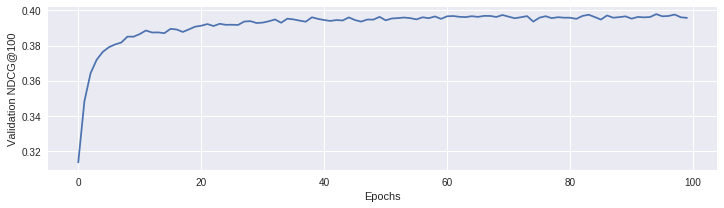

In [0]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

### Load the test data and compute test metrics

In [0]:
test_data_tr, test_data_te = load_tr_te_data('test_tr.csv','test_te.csv')

In [0]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 2000

In [0]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()    

INFO:tensorflow:Scale of 0 disables regularizer.


Load the best performing model on the validation set

In [0]:
chkpt_dir = '/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [0]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I/model


In [0]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.39521 (0.00238)
Test Recall@20=0.40720 (0.00328)
Test Recall@50=0.54470 (0.00336)


### Train a Multi-DAE

The generative function is a [200 -> n_items] MLP, thus the overall architecture for the Multi-DAE is [n_items -> 200 -> n_items]. We find this architecture achieves better validation NDCG@100 than the [n_items -> 600 -> 200 -> 600 -> n_items] architecture as used in Multi-VAE^{PR}.

In [0]:
p_dims = [200, n_items]

In [0]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

Set up logging and checkpoint directory

In [0]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))

In [0]:
log_dir = '/volmount/log/ml-20m/DAE/{}'.format(arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /volmount/log/ml-20m/DAE/I-200-I


In [0]:
chkpt_dir = '/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/DAE/I-200-I


In [0]:
n_epochs = 100

In [0]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
                    
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

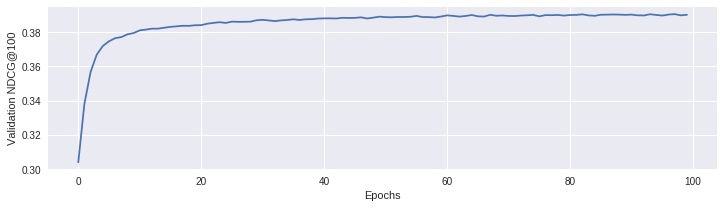

In [0]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

### Compute test metrics

In [0]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size)
saver, logits_var, _, _, _ = dae.build_graph()    

Load the best performing model on the validation set

In [0]:
chkpt_dir = '/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/DAE/I-200-I


In [0]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:    
    saver.restore(sess, '{}/model'.format(chkpt_dir))
    
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from /volmount/chkpt/ml-20m/DAE/I-200-I/model


In [0]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.38771 (0.00238)
Test Recall@20=0.39666 (0.00325)
Test Recall@50=0.53241 (0.00337)
